In [1]:
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torchvision

import torchbearer

from playground_utils import * # get common imports / vars for all nbs
all_module_versions(globals())

seaborn (0.9.0)
pandas (0.25.1)
torch (1.3.0)
torchvision (0.4.1)
torchbearer (0.5.0)


In [2]:
save_path = Path('~/Documents/data/torchvision/')

DEVICE = print_and_return( torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') )
NUM_WORKERS = 0 # print_and_return( os.cpu_count() )
BATCH_SIZE  = 256

cpu


In [3]:
normalize  = torchvision.transforms.Normalize(**IMAGENET_NORMALIZATION)
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             normalize])

# DATASETS
ds = torchvision.datasets.CIFAR10(str(save_path), train=True,  download=True, transform=transforms)
splitter = torchbearer.cv_utils.DatasetValidationSplitter(len(ds), 0.1)

train_ds = splitter.get_train_dataset(ds)
valid_ds = splitter.get_val_dataset(ds)
test_ds  = torchvision.datasets.CIFAR10(str(save_path), train=False, download=True, transform=transforms)

# DATALOADERS
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dl  = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

classes = ds.classes

print(len(train_ds))
print(len(valid_ds))
print(len(test_ds))

Files already downloaded and verified
Files already downloaded and verified
45000
5000
10000


In [4]:
get_dataset_distribution(train_ds, classes)

100%|██████████| 45000/45000 [00:07<00:00, 6399.32it/s]


Counter({'frog': 4486,
         'airplane': 4480,
         'ship': 4506,
         'dog': 4483,
         'automobile': 4505,
         'bird': 4502,
         'deer': 4462,
         'horse': 4534,
         'cat': 4512,
         'truck': 4530})

In [5]:
??torchbearer.INPUT

In [6]:
inverse_normalize  = torchvision.transforms.Normalize(**INVERSE_IMAGENET_NORMALIZATION)

make_grid = torchbearer.callbacks.imaging.MakeGrid(torchbearer.INPUT, num_images=64,
                                                   nrow=8, transform=inverse_normalize)

make_grid.on_test().to_pyplot().to_file('sample.png')

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 64 * 3 * 3)
        return self.classifier(x)


model = SimpleModel()

print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(3 * 32 * 32 * 45_000)

print('# elements per parameter:')
for p in model.parameters():
    print(p.numel())

29578
138240000
# elements per parameter:
432
16
16
16
4608
32
32
32
18432
64
64
64
5760
10


In [8]:
@torchbearer.callbacks.on_start_epoch
def on_start_epoch(state):
    if state[torchbearer.EPOCH] == 1:
        pprint(state.keys())

In [9]:
optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=1e-3)
loss = nn.CrossEntropyLoss()
cbs = [make_grid, on_start_epoch]
n_epochs = 8

trial = torchbearer.Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=cbs).to(DEVICE)
trial.with_generators(train_generator=train_dl, val_generator=valid_dl, test_generator=test_dl)

history = trial.run(epochs=n_epochs, verbose=1)

dict_keys([max_epochs, stop_training, model, criterion, optimizer, metric_list, callback_list, device, dtype, self, history, backward_args, train_generator, validation_generator, test_generator, train_steps, validation_steps, test_steps, train_data, validation_data, test_data, inf_train_loading, loader, epoch, data, sampler, generator, steps, iterator, metrics, t, x, y_true, y_pred, loss])



In [10]:
type(history), len(history)

(list, 8)

In [11]:
type(history[0]), history[0].keys()

(dict,
 dict_keys(['running_acc', 'running_loss', 'acc', 'loss', 'val_acc', 'val_loss', 'train_steps', 'validation_steps']))

In [12]:
get_data = lambda key : pd.DataFrame.from_dict({
    'epoch' : list(range(n_epochs)),
    key     : [epoch[key] for epoch in history]
})

plot = lambda key : sns.lineplot(x='epoch', y=key, data=get_data(key))

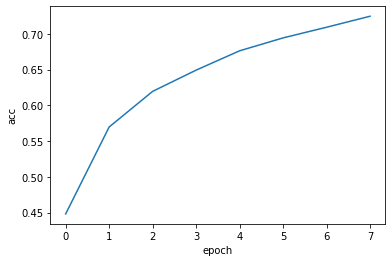

In [13]:
plot('acc')

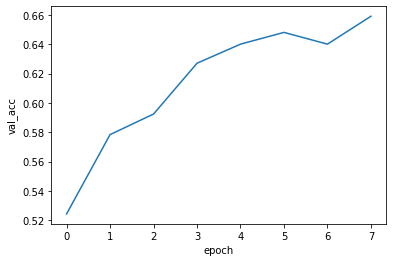

In [14]:
plot('val_acc')